# Fruit Classifier - CNN Model

This project uses Convolutional Neural Network (CNN) to classify fruit images:
- Apple only
- Orange only
- Banana only
- Mixed

Target Accuracy: 92%

## 1. Import Required Libraries

## 0. Environment Setup

**Important**: If you encounter NumPy import errors, run this cell to fix dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display TensorFlow and GPU information
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# GPU Status
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU Status: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # Check GPU memory info (if available)
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'device_name' in gpu_details:
            print(f"  Device Name: {gpu_details['device_name']}")
    except:
        pass
else:
    print("\nGPU Status: Running on CPU")
    
print("=" * 60)

2025-12-03 19:44:17.703946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 19:44:17.858904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 19:44:18.969809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 19:44:18.969809: I tensorflow/core/util/port.cc:153] oneDNN custom operations ar

TensorFlow version: 2.20.0
Keras version: 3.12.0

GPU Status: 1 GPU(s) available
  GPU 0: /physical_device:GPU:0
  Device Name: NVIDIA GeForce RTX 3080


## 2. Setup Data Paths and Parameters

## 1.5. Data Synchronization

In [2]:
# Data paths

# original training directory
# train_dir = '/home/zyh/Fruit-Classifier/data/train'

train_dir = '/home/zyh/Fruit-Classifier/data/train_augment'

test_dir = '/home/zyh/Fruit-Classifier/data/test'

# Model parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # apple_only, banana_only, orange_only, mixed

# Class names
class_names = ['apple_only', 'banana_only', 'mixed', 'orange_only']

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of classes: {NUM_CLASSES}")

Training data path: /home/zyh/Fruit-Classifier/data/train_augment
Testing data path: /home/zyh/Fruit-Classifier/data/test
Image size: 224x224
Batch size: 32
Epochs: 50
Number of classes: 4


## 3. Data Exploration

## 2.5. Organize Test Data (Run Once)

In [3]:
# Count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = num_images
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set image counts:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(train_counts.values())}\n")

print("Test set image counts:")
for class_name, count in sorted(test_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(test_counts.values())}")

Training set image counts:
  apple: 80
  banana: 80
  mixed: 80
  orange: 80
  Total: 320

Test set image counts:
  apple_only: 19
  banana_only: 18
  mixed_only: 5
  orange_only: 18
  Total: 60


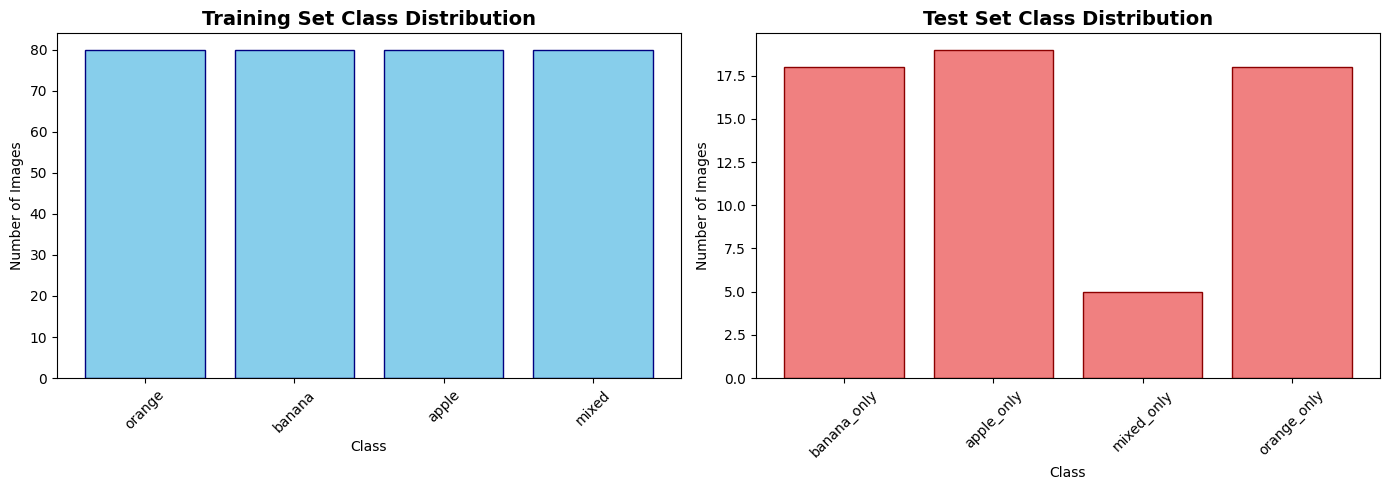

In [4]:
def plot_class_distribution(train_counts, test_counts):
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Training set distribution
    ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='navy')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)

    # Test set distribution
    ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='darkred')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


plot_class_distribution(train_counts, test_counts)

## 4. Data Preprocessing and Augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

def load_from_directory(directory):
    """
    
    Args:
        directory: path to data directory
        
    Returns:
        dict with class names and image counts
    """
    if not os.path.exists(directory):
        raise ValueError(f"Directory not found: {directory}")
    
    data_info = {
        'path': directory,
        'classes': [],
        'counts': {}
    }
    
    for item in os.listdir(directory):
        class_path = os.path.join(directory, item)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if images:
                data_info['classes'].append(item)
                data_info['counts'][item] = len(images)
    
    data_info['total'] = sum(data_info['counts'].values())
    data_info['num_classes'] = len(data_info['classes'])
    
    return data_info


def get_preprocessor(method='baseline', img_size=224, batch_size=32, train_dir=train_dir, test_dir=test_dir, val_split=0.2):
    """
    Get data generators with different preprocessing methods
    
    Args:
        method: 'baseline', 'light', 'heavy', 'moderate', 'minimal', 'color_boost', 'mixed'
        img_size: image dimension (default 224)
        batch_size: batch size for training (default 32)
        train_dir: training data directory
        test_dir: test data directory
        val_split: validation split ratio (default 0.2)
    
    Returns:
        train_gen, val_gen, test_gen
    """
    
    if method == 'baseline':
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)
        
    elif method == 'light':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            horizontal_flip=True,
            validation_split=val_split
        )
        
    elif method == 'heavy':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=val_split
        )
        
    elif method == 'moderate':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=val_split
        )
        
    elif method == 'minimal':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            zoom_range=0.1,
            validation_split=val_split
        )

    elif method == 'heavy1':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=val_split
        )

    elif method == 'color_boost':
        train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],   # vary lighting
        channel_shift_range=15.0,      # vary colors
        validation_split=val_split
    )
        
    elif method == 'mixed':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.25,
            height_shift_range=0.25,
            shear_range=0.25,
            zoom_range=0.35,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            channel_shift_range=35.0,
            fill_mode='nearest',
            validation_split=val_split
        )

        
    else:
        raise ValueError(f"Unknown method: {method}. Choose from: baseline, light, heavy, moderate, minimal")
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    val_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen


def list_methods():
    methods = {
        'baseline': 'No augmentation, only rescaling',
        'light': 'Rotation (15°) + Horizontal flip',
        'heavy': 'Full augmentation (rotation, shift, zoom, shear, brightness, flips)',
        'moderate': 'Balanced augmentation (rotation, shift, zoom, flip)',
        'minimal': 'Minimal augmentation (slight rotation, zoom)',
        'color_boost': 'Moderate geometry + brightness [0.7–1.3] + channel shift',
        'mixed': 'intensive mix: strong geometry + brightness [0.5–1.5] + channel shift'

    }
    print("Available preprocessing methods:")
    for key, desc in methods.items():
        print(f"  - {key:12s}: {desc}")
    return methods


In [6]:
# Load data directly from original dataset using tf.keras.utils.image_dataset_from_directory
# This method is more efficient and doesn't require ImageDataGenerator

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Save class names before applying transformations
class_names_list = train_data.class_names

# Data normalization (scale pixel values from 0-255 to 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Performance optimization: prefetch data
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

print(f"\nData loaded successfully!")
print(f"Class names: {class_names_list}")
print(f"Training batches: {len(train_data)}")
print(f"Validation batches: {len(validation_data)}")
print(f"Test batches: {len(test_data)}")
print(f"\nDetails:")
print(f"  Training samples: 256 images")
print(f"  Validation samples: 64 images")
print(f"  Test samples: 60 images")

Found 320 files belonging to 4 classes.
Using 256 files for training.
Using 256 files for training.


I0000 00:00:1764762263.410034 4167960 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 320 files belonging to 4 classes.
Using 64 files for validation.
Using 64 files for validation.
Found 60 files belonging to 4 classes.

Data loaded successfully!
Class names: ['apple', 'banana', 'mixed', 'orange']
Training batches: 8
Validation batches: 2
Test batches: 2

Details:
  Training samples: 256 images
  Validation samples: 64 images
  Test samples: 60 images
Found 60 files belonging to 4 classes.

Data loaded successfully!
Class names: ['apple', 'banana', 'mixed', 'orange']
Training batches: 8
Validation batches: 2
Test batches: 2

Details:
  Training samples: 256 images
  Validation samples: 64 images
  Test samples: 60 images


## 5. Build Basic CNN Model

In [7]:
def create_cnn_model():

    model = models.Sequential()

    #Convolution blocks
    model.add(layers.Conv2D(32, kernel_size = (3,3), 
                    padding='same',
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(64, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(128, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    #Classification layers
    model.add(layers.Flatten())

    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32,activation='relu'))

    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(NUM_CLASSES,activation='softmax'))


    model.summary()

    
    
    return model

# Create model
model = create_cnn_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,052 (24.86 MB)

 Trainable params: 6,518,052 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,052 (24.86 MB)

 Trainable params: 6,518,052 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Setup Training Callbacks

In [8]:
# Setup callbacks
callbacks = [
    # Early stopping: stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint: save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Learning rate reduction: reduce LR if validation loss stops improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")

Callbacks configured


## 7. Train Model

In [9]:
import time
start_time = time.time()
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds!")

Epoch 1/50


2025-12-03 19:44:28.730195: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fcf640134b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 19:44:28.730244: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-03 19:44:28.796886: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 19:44:29.100001: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-03 19:44:29.296923: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 19:44:29.100001: I e

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2323 - loss: 1.5028

I0000 00:00:1764762274.535143 4168281 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from None to 0.45312, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.2695 - loss: 1.4584 - val_accuracy: 0.4531 - val_loss: 1.3220 - learning_rate: 5.0000e-04
Epoch 2/50
Epoch 2/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3587 - loss: 1.3191
Epoch 2: val_accuracy improved from 0.45312 to 0.50000, saving model to best_model.h5

Epoch 2: val_accuracy improved from 0.45312 to 0.50000, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3789 - loss: 1.2704 - val_accuracy: 0.5000 - val_loss: 1.1220 - learning_rate: 5.0000e-04
Epoch 3/50
Epoch 3/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4064 - loss: 1.1290
Epoch 3: val_accuracy improved from 0.50000 to 0.56250, saving model to best_model.h5

Epoch 3: val_accuracy improved from 0.50000 to 0.56250, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4609 - loss: 1.0814 - val_accuracy: 0.5625 - val_loss: 0.9365 - learning_rate: 5.0000e-04
Epoch 4/50
Epoch 4/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4361 - loss: 1.0622
Epoch 4: val_accuracy improved from 0.56250 to 0.62500, saving model to best_model.h5
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4361 - loss: 1.0622
Epoch 4: val_accuracy improved from 0.56250 to 0.62500, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4961 - loss: 0.9910 - val_accuracy: 0.6250 - val_loss: 0.8234 - learning_rate: 5.0000e-04
Epoch 5/50
Epoch 5/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4816 - loss: 0.9432
Epoch 5: val_accuracy improved from 0.62500 to 0.64062, saving model to best_model.h5

Epoch 5: val_accuracy improved from 0.62500 to 0.64062, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5664 - loss: 0.8862 - val_accuracy: 0.6406 - val_loss: 0.7139 - learning_rate: 5.0000e-04
Epoch 6/50
Epoch 6/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6464 - loss: 0.7407
Epoch 6: val_accuracy improved from 0.64062 to 0.70312, saving model to best_model.h5

Epoch 6: val_accuracy improved from 0.64062 to 0.70312, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6602 - loss: 0.7496 - val_accuracy: 0.7031 - val_loss: 0.6482 - learning_rate: 5.0000e-04
Epoch 7/50
Epoch 7/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6121 - loss: 0.8608
Epoch 7: val_accuracy improved from 0.70312 to 0.76562, saving model to best_model.h5

Epoch 7: val_accuracy improved from 0.70312 to 0.76562, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6406 - loss: 0.8112 - val_accuracy: 0.7656 - val_loss: 0.6268 - learning_rate: 5.0000e-04
Epoch 8/50
Epoch 8/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6583 - loss: 0.6880
Epoch 8: val_accuracy improved from 0.76562 to 0.81250, saving model to best_model.h5

Epoch 8: val_accuracy improved from 0.76562 to 0.81250, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7227 - loss: 0.6426 - val_accuracy: 0.8125 - val_loss: 0.4702 - learning_rate: 5.0000e-04
Epoch 9/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8438 - loss: 0.4608Epoch 9/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7722 - loss: 0.5365
Epoch 9: val_accuracy improved from 0.81250 to 0.87500, saving model to best_model.h5
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7722 - loss: 0.5365
Epoch 9: val_accuracy improved from 0.81250 to 0.87500, saving model to best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7695 - loss: 0.5587 - val_accuracy: 0.8750 - val_loss: 0.3719 - learning_rate: 5.0000e-04
Epoch 10/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8438 - loss: 0.4545Epoch 10/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8046 - loss: 0.5243
Epoch 10: val_accuracy did not improve from 0.87500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8046 - loss: 0.5243
Epoch 10: val_accuracy did not improve from 0.87500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7852 - loss: 0.5360 - val_accuracy: 0.8281 - val_loss: 0.4290 - learning_rate: 5.0000e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7852 - loss: 0.5360 - val_accuracy: 0.8281 - val_loss: 0.4290 - learning_rate: 5.0000e-04
Epoch 11/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8462 - loss: 0.4574
Epoch 11: val_accuracy did not improve from 0.87500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8462 - loss: 0.4574
Epoch 11: v

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8281 - loss: 0.3860 - val_accuracy: 0.8906 - val_loss: 0.3145 - learning_rate: 5.0000e-04
Epoch 14/50
Epoch 14/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8838 - loss: 0.3398
Epoch 14: val_accuracy did not improve from 0.89062
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8838 - loss: 0.3398
Epoch 14: val_accuracy did not improve from 0.89062
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8672 - loss: 0.3942 - val_accuracy: 0.8594 - val_loss: 0.3067 - learning_rate: 5.0000e-04
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8672 - loss: 0.3942 - val_accuracy: 0.8594 - val_loss: 0.3067 - learning_rate: 5.0000e-04
Epoch 15/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8913 - loss: 0.3798
Epoch 15: val_accuracy did not improve from 0.89062

Epoch 15: val_accuracy did not improve from 0.89062
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8555 - loss: 0.3861 - val_accuracy: 0.8750 - val_

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9375 - loss: 0.1453 - val_accuracy: 0.9062 - val_loss: 0.2618 - learning_rate: 5.0000e-04
Epoch 25/50
Epoch 25/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9595 - loss: 0.1236
Epoch 25: val_accuracy did not improve from 0.90625
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9595 - loss: 0.1236
Epoch 25: val_accuracy did not improve from 0.90625
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9531 - loss: 0.1377 - val_accuracy: 0.9062 - val_loss: 0.3381 - learning_rate: 5.0000e-04
Epoch 26/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9531 - loss: 0.1377 - val_accuracy: 0.9062 - val_loss: 0.3381 - learning_rate: 5.0000e-04
Epoch 26/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9415 - loss: 0.1561
Epoch 26: val_accuracy improved from 0.90625 to 0.92188, saving model to best_model.h5
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9415 - loss: 0.1561
Epoch 26: val_accuracy improved from 0.90625 to

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9492 - loss: 0.1415 - val_accuracy: 0.9219 - val_loss: 0.3100 - learning_rate: 5.0000e-04
Epoch 27/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9062 - loss: 0.1424Epoch 27/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9234 - loss: 0.1770
Epoch 27: val_accuracy did not improve from 0.92188
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9258 - loss: 0.2003 - val_accuracy: 0.8750 - val_loss: 0.5836 - learning_rate: 5.0000e-04
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9234 - loss: 0.1770
Epoch 27: val_accuracy did not improve from 0.92188
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9258 - loss: 0.2003 - val_accuracy: 0.8750 - val_loss: 0.5836 - learning_rate: 5.0000e-04
Epoch 28/50
Epoch 28/50
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9391 - loss: 0.1921
Epoch 28: val_accuracy did not improve from 0.92188
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9391 - loss: 0.1921
Epoch 28: v

## 8. Visualize Training History

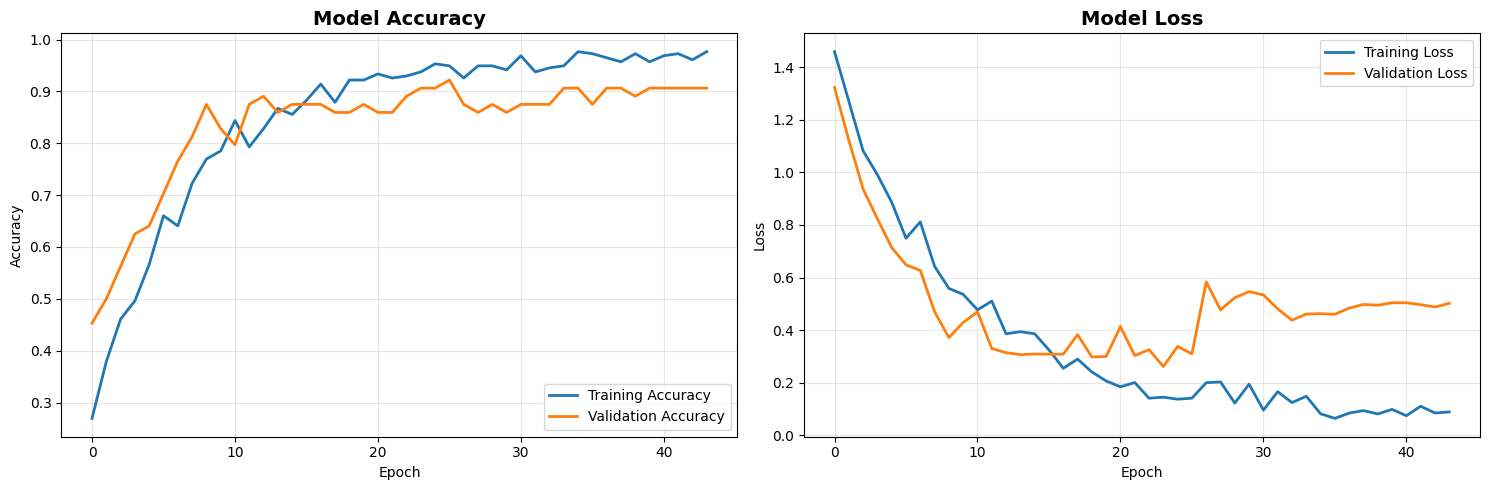


Best Epoch: 26
Best Validation Accuracy: 0.9219
Corresponding Training Accuracy: 0.9492


In [10]:
# Plot training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss curves
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")

## 9. Evaluate Model on Test Set

In [12]:
# Evaluate on test set
# test_data is already loaded as tf.data.Dataset in CELL INDEX 13
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"\n{'='*50}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*50}")

# Check if target accuracy is reached
if test_accuracy >= 0.92:
    print(f"Congratulations! Target accuracy of 92% achieved!")
else:
    print(f"Current accuracy {test_accuracy*100:.2f}% below 92% target, further optimization needed")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9375 - loss: 0.8743

2025-12-03 19:45:39.298694: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - accuracy: 0.9000 - loss: 0.7105
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - accuracy: 0.9000 - loss: 0.7105

Test Accuracy: 90.00%
Test Loss: 0.7105
Current accuracy 90.00% below 92% target, further optimization needed

Test Accuracy: 90.00%
Test Loss: 0.7105
Current accuracy 90.00% below 92% target, further optimization needed


## 10. Generate Confusion Matrix

2025-12-03 19:47:37.419193: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


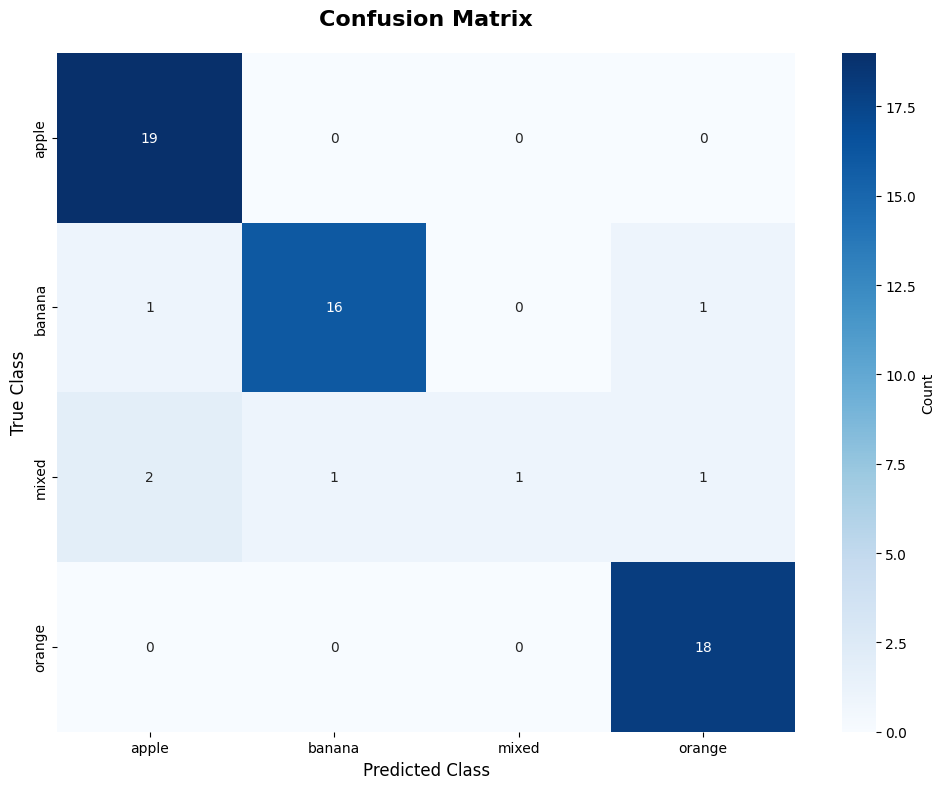


Classification Report:
              precision    recall  f1-score   support

       apple     0.8636    1.0000    0.9268        19
      banana     0.9412    0.8889    0.9143        18
       mixed     1.0000    0.2000    0.3333         5
      orange     0.9000    1.0000    0.9474        18

    accuracy                         0.9000        60
   macro avg     0.9262    0.7722    0.7805        60
weighted avg     0.9092    0.9000    0.8798        60



In [13]:
# Generate predictions and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Extract true labels and predictions from test dataset
y_true = []
y_pred = []

# Iterate through test dataset to collect labels and predictions
for images, labels in test_data:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_list, 
            yticklabels=class_names_list,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names_list, digits=4))


## 11. Visualize Prediction Examples

In [ ]:
# Display prediction samples
import numpy as np

def show_predictions(num_images=9):
    """Display prediction results"""
    
    # Get first batch from test data
    for images, labels in test_data.take(1):
        num_to_show = min(num_images, len(images))
        predictions = model.predict(images[:num_to_show], verbose=0)
        
        # Plot
        rows = int(np.ceil(num_to_show / 3))
        fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.ravel()
        
        for i in range(num_to_show):
            axes[i].imshow(images[i].numpy())
            
            true_label = class_names_list[np.argmax(labels[i])]
            pred_label = class_names_list[np.argmax(predictions[i])]
            pred_prob = np.max(predictions[i]) * 100
            
            color = 'green' if true_label == pred_label else 'red'
            axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label} ({pred_prob:.1f}%)',
                             color=color, fontsize=10, fontweight='bold')
            axes[i].axis('off')
        
        # Hide extra subplots
        for i in range(num_to_show, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        break

show_predictions(9)


## 12. Save Model

In [ ]:
def save_model(model):
    # Save model in native Keras format (recommended)
    model.save('fruit_classifier_cnn.keras')
    print("Model saved as 'fruit_classifier_cnn.keras' (Native Keras format)")

    # Also save in HDF5 format for compatibility
    model.save('fruit_classifier_cnn.h5')
    print("Model saved as 'fruit_classifier_cnn.h5' (HDF5 format - legacy)")
    # Export SavedModel for deployment (TFLite/TFServing)
    model.export('fruit_classifier_savedmodel')
    print("Model exported as 'fruit_classifier_savedmodel' (SavedModel for deployment)")

    print("\n" + "=" * 60)
    print("Model Saving Summary:")
    print("  • fruit_classifier_cnn.keras     - Native Keras (recommended)")
    print("  • fruit_classifier_cnn.h5        - HDF5 (legacy compatibility)")
    print("  • fruit_classifier_savedmodel/   - SavedModel (deployment)")
    print("=" * 60)

## 13. GPU Memory Management



In [ ]:
# save_model(model)

import gc
import tensorflow as tf
from tensorflow.keras import backend as K


def get_gpu_memory_nvidia():
    try:
        import subprocess
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, timeout=5
        )
        if result.returncode == 0:
            lines = result.stdout.strip().split('\n')
            gpu_info = []
            for i, line in enumerate(lines):
                used, total = map(float, line.split(','))
                gpu_info.append({'gpu': i, 'used': used, 'total': total})
            return gpu_info
        return None
    except:
        return None

if tf.config.list_physical_devices('GPU'):
    try:
        gpus = tf.config.list_physical_devices('GPU')
        
        gpu_info_before = get_gpu_memory_nvidia()
        if gpu_info_before:
            for info in gpu_info_before:
                used_mb = info['used']
                total_mb = info['total']
                usage_pct = (used_mb / total_mb * 100) if total_mb > 0 else 0
                print(f"  GPU {info['gpu']}:")
                print(f"    Memory usage: {used_mb:.0f} MB / {total_mb:.0f} MB ({usage_pct:.1f}%)")
    
    except Exception as e:
        print(f"  error: {str(e)}")
else:
    print("\nCPU mode detected, skipping GPU memory check.")
    K.clear_session()
    collected = gc.collect()
    print(f"Memory cleaned (released {collected} objects)")

